In [1]:
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

def get_random_seq_complex():
    K = 5
    arr = [np.floor(np.random.rand(3) * 5) for _ in range(K)]
    
    picks = [
        [0, -1],
        [0, -2],
        [-1, -2],
        [-2, -3],
        [-3, -4],
    ]
    
    prev = K - 1
    prev_a = 0
    
    while True:
        a = 0 if np.random.rand() < 0.5 else 1
        
        ctrl = arr[prev][0]
        pick = picks[int(ctrl)]
        
        item = np.array([
            arr[(prev + K + pick[a]) % K][1],
            arr[(prev + K + pick[1 - a]) % K][2],
            np.floor(np.random.rand() * 5)
        ])

        yield (arr[prev], a, item)
    
        prev = (prev + 1) % K

        arr[prev] = item
        
        prev_a = a

generator = get_random_seq_complex()
for _ in range(10):
    print(next(generator))

(array([4., 1., 0.]), 0, array([0., 3., 1.]))
(array([0., 3., 1.]), 1, array([1., 1., 2.]))
(array([1., 1., 2.]), 0, array([1., 0., 3.]))
(array([1., 0., 3.]), 0, array([0., 1., 1.]))
(array([0., 1., 1.]), 0, array([1., 3., 2.]))
(array([1., 3., 2.]), 1, array([0., 2., 0.]))
(array([0., 2., 0.]), 1, array([3., 0., 2.]))
(array([3., 0., 2.]), 0, array([3., 1., 3.]))
(array([3., 1., 3.]), 0, array([2., 2., 0.]))
(array([2., 2., 0.]), 1, array([0., 3., 4.]))


In [4]:
np.random.seed(42)

S = 4

def to_ohe(n, max_n):
    arr = np.zeros(max_n)
    arr[n] = 1
    return arr

# echo
def get_random_seq():
    K = 5
    arr = [np.random.randint(0, S) for _ in range(K)]
#     print(arr)
    
    picks = [-1, -2, 0]
    
    prev = K - 1
    while True:
        a = int(np.random.randint(0, 4))
        
        item = arr[(prev + K + picks[a]) % K] if a < 3 else np.random.randint(0, S)
        
        yield (to_ohe(arr[prev], S), a, to_ohe(item, S))
    
        prev = (prev + 1) % K

        arr[prev] = item

generator = get_random_seq()
for _ in range(15):
    print(next(generator))

(array([0., 0., 1., 0.]), 3, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 0, array([0., 0., 1., 0.]))
(array([0., 0., 1., 0.]), 2, array([0., 0., 1., 0.]))
(array([0., 0., 1., 0.]), 1, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 2, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 2, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 2, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 2, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 3, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 3, array([0., 0., 0., 1.]))
(array([0., 0., 0., 1.]), 3, array([0., 0., 1., 0.]))
(array([0., 0., 1., 0.]), 1, array([1., 0., 0., 0.]))
(array([1., 0., 0., 0.]), 0, array([0., 0., 1., 0.]))
(array([0., 0., 1., 0.]), 1, array([0., 0., 1., 0.]))
(array([0., 0., 1., 0.]), 3, array([0., 0., 0., 1.]))


In [5]:
def get_rnn_batches(generator, B, rnn_steps):
    while True:
        X  = np.zeros((B, rnn_steps, S))
        A  = np.zeros((B, rnn_steps))
        NX = np.zeros((B, rnn_steps, S))

        for i in range(B * rnn_steps):
            s, a, ns = next(generator)
            
            bi = i // rnn_steps
            si = i % rnn_steps

            X[bi, si, :] = s
            A[bi, si] = a
            NX[bi, si, :] = ns

        yield X, A, NX
    
np.random.seed(42)
generator = get_rnn_batches(get_random_seq(), 2, 3)
for _ in range(1):
    print(next(generator))

(array([[[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]]), array([[3., 0., 2.],
       [1., 2., 2.]]), array([[[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]]))



[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[3. 0. 2. 0.]
[[[ 0.09649572  0.1229775   0.6197754  -0.32674837]]]
[0. 0. 1. 0.]


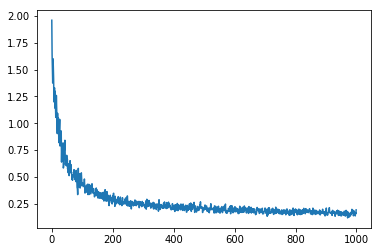

In [6]:
def build_graph(S, A, rnn_steps, rnn_state_size):
    rnn_s  = tf.placeholder("float", [None, None, S], name="Placeholder_rnn_s")
    rnn_ns = tf.placeholder("float", [None, None, S], name="Placeholder_rnn_ns")
    rnn_a  = tf.placeholder("int32", [None, None], name="Placeholder_rnn_a")

#     zeros_dims = tf.stack([tf.shape(rnn_s)[0], rnn_state_size])
#     rnn_is = tf.fill(zeros_dims, 0.0, name="RNN_init_state")

    action_ohe = tf.one_hot(rnn_a, depth=A)
    state_and_action = tf.concat([rnn_s, action_ohe], axis=2)

    rnn_cell = tf.contrib.rnn.LSTMCell(
        rnn_state_size,
        num_proj=S,
        initializer=tf.random_uniform_initializer(-1, 1))

    rnn_is = rnn_cell.zero_state(tf.shape(rnn_s)[0], tf.float32)
#     LSTMStateTuple(
#         c=<tf.Tensor 'LSTMCellZeroState/zeros:0' shape=(?, rnn_state_size) dtype=float32>,
#         h=<tf.Tensor 'LSTMCellZeroState/zeros_1:0' shape=(?, S) dtype=float32>)
    
#     rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [10, 20]]
#     rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)

#     rnn_cell = tf.nn.rnn_cell.BasicRNNCell(rnn_state_size)
#     rnn_cell = tf.contrib.rnn.OutputProjectionWrapper(rnn_cell, S)

    predictions, rnn_final_state = tf.nn.dynamic_rnn(rnn_cell, state_and_action,
                                       initial_state=(rnn_is),
                                       dtype=tf.float32)

    rnn_cost = tf.reduce_mean(tf.squared_difference(predictions, rnn_ns))
    
    return {
        'rnn_s': rnn_s,
        'rnn_ns': rnn_ns,
        'rnn_a': rnn_a,
        'rnn_is': rnn_is,
        'rnn_final_state': rnn_final_state,
        'rnn_cost': rnn_cost,
        'rnn_predictions': predictions,
        'rnn_train_op': tf.train.GradientDescentOptimizer(learning_rate=learning_rate) \
            .minimize(rnn_cost),
    }

def train():
#     np.random.seed(42)
    
    B = 32
    S = 4
    A = 4
    rnn_state_size = 100
    rnn_steps = 5
    
    tf.reset_default_graph()
    graph = build_graph(S, A, rnn_steps, rnn_state_size)
    
    tf_rnn_s = graph['rnn_s']
    tf_rnn_ns = graph['rnn_ns']
    tf_rnn_a = graph['rnn_a']
    tf_rnn_is = graph['rnn_is']
    tf_rnn_final_state = graph['rnn_final_state']
    tf_rnn_cost = graph['rnn_cost']
    tf_rnn_predictions = graph['rnn_predictions']
    tf_rnn_train_op = graph['rnn_train_op']
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        
        generator = get_rnn_batches(get_random_seq(), B, rnn_steps)
        
        costs = []

        for train_step in range(steps_to_train):
            # TODO: Check to put it outside of batch loop
            RNN_State = (np.zeros((B, rnn_state_size)), np.zeros((B, S)))
            X, A, NX = next(generator)
        
            cost, RNN_State, _ = \
                session.run([tf_rnn_cost, tf_rnn_final_state, tf_rnn_train_op],
                          feed_dict={tf_rnn_s: X,
                                     tf_rnn_ns: NX,
                                     tf_rnn_a: A,
                                     tf_rnn_is: RNN_State})
            costs.append(cost)  
            
            if train_step == steps_to_train - 1:
                
                last_input = np.zeros((1, 1, S))
                last_state_c = np.zeros((1, rnn_state_size))
                last_state_h = np.zeros((1, S))
                last_a = np.zeros((1, 1))
                
#                 print(X.shape)          # (32, 3, 3)
#                 print(RNN_State.shape)  # (32, 10)
#                 print(A.shape)          # (32, 3)
                last_input[0, 0, :] = X[-1, -1, :]
                last_state_c[0, :] = RNN_State[0][-1, :]
                last_state_h[0, :] = RNN_State[1][-1, :]
                last_a[0, 0] = A[-1, -1]
                
                pred, cell_state = session.run(
                    [tf_rnn_predictions, tf_rnn_final_state],
                      feed_dict={
                          tf_rnn_s: last_input,
                          tf_rnn_a: last_a,
                          tf_rnn_is: (last_state_c, last_state_h),
                      })
                
                print('')
                print(X[-1, -4:, :])
                print(A[-1, -4:])
                print(pred)
                print(NX[-1, -1, :])
            
        plt.plot(costs)
            
learning_rate = 0.03
steps_to_train = 1000
train()

In [137]:
?tf.TensorArray

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [20]:
print(gen_data(100))

(array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]), array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]))


In [19]:
for x,y in gen_batch(gen_data(100), 3, 5):
    print(x)
    print(y)
    print('')

[[0 1 0 0 0]
 [1 0 1 0 1]
 [1 0 1 1 1]]
[[1 1 1 1 1]
 [1 0 0 1 1]
 [1 0 1 0 1]]

[[1 1 1 1 0]
 [0 0 0 1 1]
 [1 0 1 1 1]]
[[0 0 0 1 1]
 [1 0 1 0 0]
 [1 1 1 1 0]]

[[1 0 1 0 0]
 [1 1 0 0 1]
 [0 0 1 1 1]]
[[1 1 0 1 0]
 [1 1 1 1 1]
 [1 0 1 1 0]]

[[1 1 1 1 1]
 [1 1 1 1 0]
 [1 0 1 0 0]]
[[1 0 1 1 1]
 [1 0 1 1 1]
 [0 0 0 1 1]]

[[0 0 1 0 0]
 [1 1 0 0 0]
 [0 0 1 1 1]]
[[1 1 1 1 1]
 [1 1 0 1 1]
 [0 0 0 0 0]]

[[0 1 1 1 0]
 [0 1 1 1 1]
 [1 1 1 0 0]]
[[0 0 0 0 1]
 [0 0 0 0 1]
 [1 1 1 1 1]]



In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [5]:
print('x', x)
print('y', y)
print('init_state', init_state)
print('x_one_hot', x_one_hot)
print('rnn_inputs', rnn_inputs)

('x', <tf.Tensor 'input_placeholder:0' shape=(200, 5) dtype=int32>)
('y', <tf.Tensor 'labels_placeholder:0' shape=(200, 5) dtype=int32>)
('init_state', <tf.Tensor 'zeros:0' shape=(200, 4) dtype=float32>)
('x_one_hot', <tf.Tensor 'one_hot:0' shape=(200, 5, 2) dtype=float32>)
('rnn_inputs', [<tf.Tensor 'unstack:0' shape=(200, 2) dtype=float32>, <tf.Tensor 'unstack:1' shape=(200, 2) dtype=float32>, <tf.Tensor 'unstack:2' shape=(200, 2) dtype=float32>, <tf.Tensor 'unstack:3' shape=(200, 2) dtype=float32>, <tf.Tensor 'unstack:4' shape=(200, 2) dtype=float32>])


In [6]:
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

In [7]:
print('cell', cell)
print('rnn_outputs', rnn_outputs)
print('final_state', final_state)

('cell', <tensorflow.python.ops.rnn_cell_impl.BasicRNNCell object at 0x11d930c50>)
('rnn_outputs', [<tf.Tensor 'rnn/basic_rnn_cell/Tanh:0' shape=(200, 4) dtype=float32>, <tf.Tensor 'rnn/basic_rnn_cell/Tanh_1:0' shape=(200, 4) dtype=float32>, <tf.Tensor 'rnn/basic_rnn_cell/Tanh_2:0' shape=(200, 4) dtype=float32>, <tf.Tensor 'rnn/basic_rnn_cell/Tanh_3:0' shape=(200, 4) dtype=float32>, <tf.Tensor 'rnn/basic_rnn_cell/Tanh_4:0' shape=(200, 4) dtype=float32>])
('final_state', <tf.Tensor 'rnn/basic_rnn_cell/Tanh_4:0' shape=(200, 4) dtype=float32>)


In [8]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [9]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

('\nEPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.604746658205986)
('Average loss at step', 200, 'for last 250 steps:', 0.5271763280034065)
('Average loss at step', 300, 'for last 250 steps:', 0.5199118518829345)
('Average loss at step', 400, 'for last 250 steps:', 0.520693002641201)
('Average loss at step', 500, 'for last 250 steps:', 0.5188594949245453)
('Average loss at step', 600, 'for last 250 steps:', 0.5197544082999229)
('Average loss at step', 700, 'for last 250 steps:', 0.5196706667542458)
('Average loss at step', 800, 'for last 250 steps:', 0.5206723693013191)
('Average loss at step', 900, 'for last 250 steps:', 0.5197061768174172)


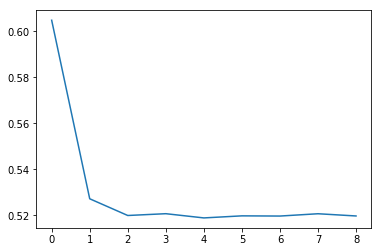

In [10]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)